In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,datetime,timedelta
from scipy.spatial.distance import cdist
from sklearn import cluster
%matplotlib inline

# Data preperation

In [2]:
#read in csv file
df = pd.read_csv("consumption_loadcourse_excl_Linz.csv")

/Users/tamo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#convert to datetime format and ad new "date" and "hour"-column in datetime format

df["datetime"] = pd.to_datetime(df["Datum"],dayfirst = True) + df["Hour_of_Day"].astype("timedelta64[h]")
df.datetime.dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")

#df["date"]= df['datetime'].apply(lambda x: x.date)
df["day_of_year"] = df["datetime"].apply(lambda x: x.timetuple().tm_yday)
df["hour"]= df['datetime'].apply(lambda x: x.hour)
df.head()


,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear,day_of_year,hour
0,2009-10-06 01:00:00,1,636,391943,6/10/2009,6673,0,1,1,0,Münster,215.0,2009,279,1
1,2009-10-07 01:00:00,2,636,391943,7/10/2009,6697,0,1,1,0,Münster,196.0,2009,280,1
2,2009-10-08 01:00:00,3,636,391943,8/10/2009,6721,0,1,1,0,Münster,235.0,2009,281,1
3,2009-10-09 01:00:00,4,636,391943,9/10/2009,6745,0,1,1,0,Münster,250.0,2009,282,1
4,2009-10-10 01:00:00,5,636,391943,10/10/2009,6769,0,2,1,0,Münster,288.0,2009,283,1


In [4]:
df[df["Fall_ge1"]==636].loc["2009-10-25 02:00:00":"2009-10-25 03:00:00"]

,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear,day_of_year,hour


In [5]:
#normalisation:
df['max_energy'] = df.groupby(['Fall_ge1'])['Electricity_Demand'].transform(max)
df['norm_energy'] = df['Electricity_Demand'] / df['max_energy']

In [6]:
#Meteorological seasons:
#winter
sdate_wi = date(2009, 12, 1)   # start date
edate_wi = date(2010, 2, 28)   # end date
#spring
sdate_sp = date(2010, 3, 1)   # start date
edate_sp = date(2010, 5, 31)   # end date
#summer
sdate_su = date(2010, 6, 1)   # start date
edate_su = date(2010, 8, 31)   # end date
#Fall
sdate_fa = date(2009, 9, 1)   # start date
edate_fa = date(2009, 11, 30)   # end date

In [7]:
#filter df by season:
df_fa = df[(df["datetime"] > str(sdate_fa)) & (df["datetime"] <= str(edate_fa))]
df_wi = df[(df["datetime"] > str(sdate_wi)) & (df["datetime"] <= str(edate_wi))]
df_sp = df[(df["datetime"] > str(sdate_sp)) & (df["datetime"] <= str(edate_sp))]
df_su = df[(df["datetime"] > str(sdate_su)) & (df["datetime"] <= str(edate_su))]

In [8]:
#split dataframes into weekday and weekend days
df_fa_week=df_fa[df_fa["Weekday"]==1]
df_fa_wknd=df_fa[df_fa["Weekday"]==2]
df_wi_week=df_wi[df_wi["Weekday"]==1]
df_wi_wknd=df_wi[df_wi["Weekday"]==2]
df_sp_week=df_sp[df_sp["Weekday"]==1]
df_sp_wknd=df_sp[df_sp["Weekday"]==2]
df_su_week=df_su[df_su["Weekday"]==1]
df_su_wknd=df_su[df_su["Weekday"]==2]

In [9]:
df_sp.shape

(1029672, 17)

In [10]:
df_su.shape

(1071120, 17)

In [11]:
df_wi.shape

(933480, 17)

In [12]:
df_fa.shape

(929712, 17)

In [13]:
df.set_index("datetime", inplace = True)

# Functions for clustering

In [14]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

In [15]:
#def cluster_overview(cluster_centers)
#    sort
#    plt.plot(fall_week[x],label="Cluster " + str(x + 1))

In [16]:
# for x in range(0,5,1):
#     plt.plot(fall_week[x],label="Cluster " + str(x + 1))
# plt.legend()
# plt.title("Fall weekdays")
# plt.ylabel("normalized consumption")
# plt.xlabel("hour")

# Fall

### Fall weekday 

In [17]:
red_df=df_fa_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df

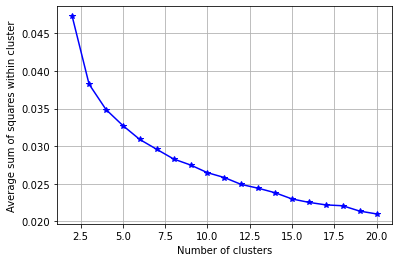

In [18]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [19]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [20]:
cls_list = algorithm.predict(kmeans_df)

kmeans_df['cluster'] = cls_list

In [21]:
fall_week = clustering.cluster_centers_
#clustering.cluster_centers_.mean(axis=1).sort()
clustering.cluster_centers_

array([[0.03565934, 0.02581252, 0.02227607, 0.02017539, 0.02042205,
        0.02300621, 0.0290803 , 0.04570507, 0.04753144, 0.04903918,
        0.04721002, 0.04480555, 0.04558532, 0.04699733, 0.04410485,
        0.04499884, 0.04433205, 0.05148348, 0.06414254, 0.06929074,
        0.07515112, 0.07011133, 0.0607705 , 0.04910615],
       [0.07079426, 0.05001142, 0.04261463, 0.03917127, 0.03824806,
        0.04454357, 0.05637905, 0.06967116, 0.08235845, 0.07899966,
        0.0779906 , 0.07962861, 0.08614086, 0.09307957, 0.08982393,
        0.08484993, 0.08789942, 0.09936794, 0.12226096, 0.13749074,
        0.14203316, 0.13229802, 0.11364495, 0.09197194],
       [0.1470506 , 0.12391367, 0.11595422, 0.11330145, 0.11165186,
        0.12348704, 0.1553872 , 0.17331981, 0.19991266, 0.20672348,
        0.21551497, 0.22076612, 0.23632243, 0.23681343, 0.22605711,
        0.21229879, 0.21063574, 0.22775552, 0.25141   , 0.26690171,
        0.27481856, 0.26259706, 0.23325325, 0.19163679],
       [0.112

Text(0.5, 0, 'hour')

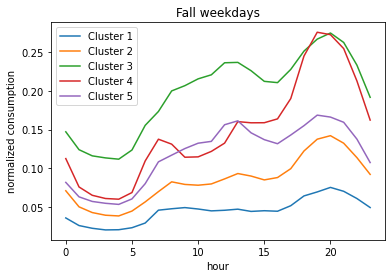

In [22]:
for x in range(0,5,1):
    plt.plot(fall_week[x],label="Cluster " + str(x + 1))
plt.legend()
plt.title("Fall weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Fall weekend 

In [23]:
red_df=df_fa_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df

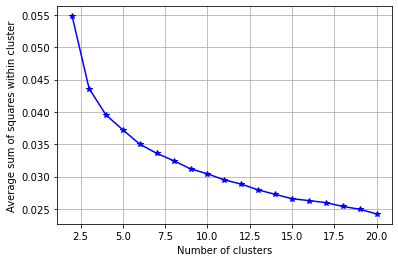

In [24]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [25]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [26]:
cls_list = algorithm.predict(kmeans_df)

kmeans_df['cluster'] = cls_list

In [27]:
fall_week = clustering.cluster_centers_
#clustering.cluster_centers_.mean(axis=1).sort()
clustering.cluster_centers_

array([[0.08940893, 0.07157123, 0.05905062, 0.05082581, 0.04817894,
        0.04822314, 0.05085175, 0.06062391, 0.07406762, 0.09252828,
        0.10245998, 0.11029894, 0.11494374, 0.11441836, 0.11341375,
        0.10533041, 0.10760609, 0.11646588, 0.13451864, 0.15233072,
        0.15630612, 0.15063096, 0.13409771, 0.11293769],
       [0.15513357, 0.1249654 , 0.10583246, 0.09347708, 0.08804206,
        0.08690267, 0.09733349, 0.11231012, 0.13656796, 0.17771543,
        0.1859349 , 0.20698955, 0.22423914, 0.24356409, 0.235007  ,
        0.22301158, 0.2233173 , 0.2609372 , 0.30849338, 0.31974779,
        0.3209952 , 0.29282797, 0.25112311, 0.20527918],
       [0.03858242, 0.03168378, 0.02691611, 0.02343625, 0.02221896,
        0.02281503, 0.0251435 , 0.03019818, 0.04169341, 0.05519281,
        0.06745903, 0.06826838, 0.07400911, 0.06620456, 0.06065032,
        0.05692119, 0.05575563, 0.05697276, 0.07074395, 0.07589226,
        0.07763725, 0.07264979, 0.06135035, 0.05165071],
       [0.056

Text(0.5, 0, 'hour')

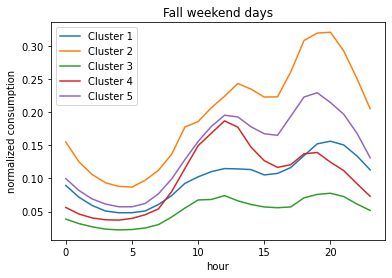

In [28]:
for x in range(0,5,1):
    plt.plot(fall_week[x],label="Cluster " + str(x + 1))
plt.legend()
plt.title("Fall weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Winter

### Winter weekdays

In [29]:
red_df=df_wi_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

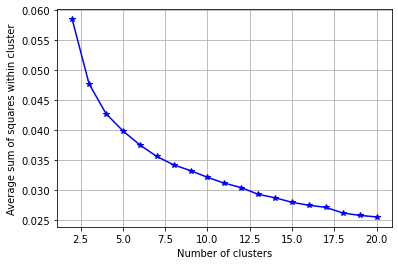

In [30]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [31]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [32]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

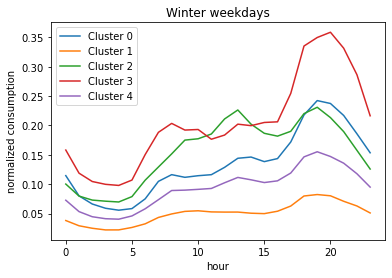

In [33]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Winter weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Winter weekend days

In [34]:
red_df=df_wi_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

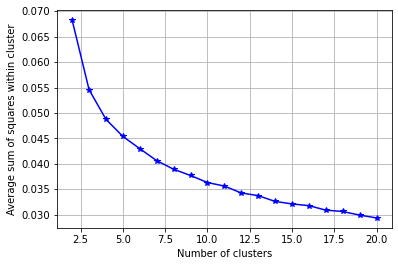

In [35]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [36]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [37]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

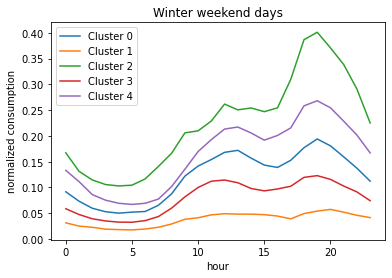

In [38]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Winter weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Spring

### Spring weekdays

In [39]:
red_df=df_sp_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

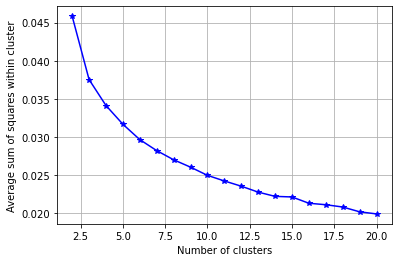

In [40]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [41]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [42]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

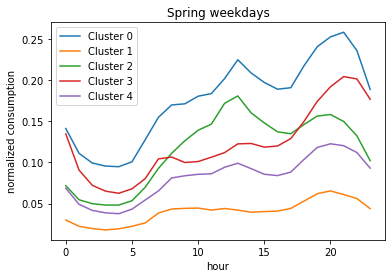

In [43]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Spring weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Spring weekend days

In [44]:
red_df=df_sp_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

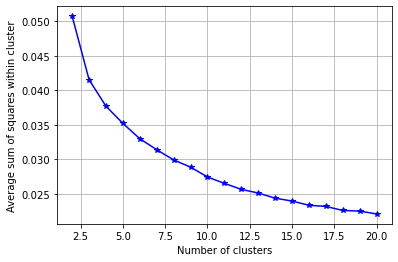

In [45]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [46]:
algorithm = k_algs[5] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[5]

In [47]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

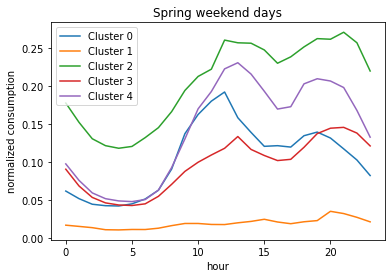

In [48]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Spring weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Summer

### Summer weekdays

In [49]:
red_df=df_su_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

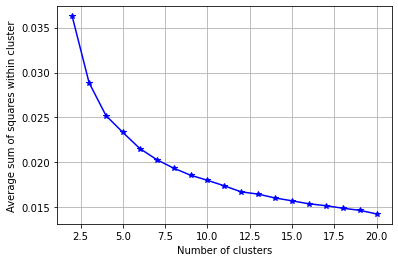

In [50]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [51]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [52]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

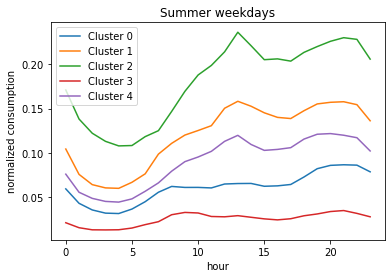

In [53]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Summer weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Summer weekend days

In [54]:
red_df=df_su_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

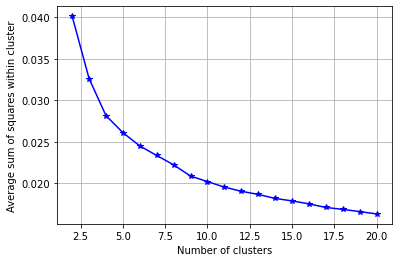

In [55]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [56]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [57]:
cls_list = algorithm.predict(kmeans_df)
kmeans_df['cluster'] = cls_list

Text(0.5, 0, 'hour')

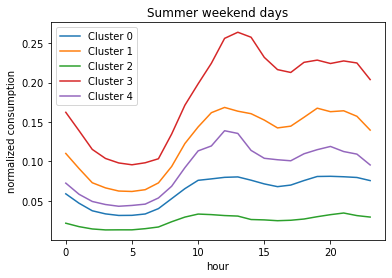

In [58]:
for x in range(0,5,1):
    plt.plot(clustering.cluster_centers_[x],label="Cluster " + str(x))
plt.legend()
plt.title("Summer weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [59]:
#multiline plot:
def multiline_hourly_plot(dataset, avg = None, ycol = 'Electricity_Demand', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()
    
    return fig

In [60]:
def clusters_visualisation(grp_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = grp_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

In [61]:
kmeans_df["Fall_ge1"]=kmeans_df.index
kmeans_df

hour,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,cluster,Fall_ge1
Fall_ge1,,,,,,,,,,,,,,,,,,,,,
1,0.081572,0.054497,0.046832,0.045064,0.045769,0.044335,0.044497,0.057457,0.081017,0.095376,...,0.060150,0.071006,0.073642,0.081803,0.106324,0.088173,0.079410,0.091457,0,1
2,0.106400,0.088498,0.062719,0.059737,0.061502,0.060394,0.057248,0.052175,0.081633,0.087350,...,0.068586,0.066617,0.077106,0.069954,0.064688,0.080470,0.092040,0.111023,0,2
3,0.132596,0.129296,0.124005,0.118633,0.115535,0.123081,0.117739,0.117952,0.118612,0.127417,...,0.148398,0.161427,0.148438,0.142000,0.139857,0.142213,0.153485,0.155648,1,3
4,0.048281,0.042021,0.035207,0.035941,0.032755,0.039029,0.035345,0.047298,0.083156,0.113099,...,0.137323,0.112892,0.123459,0.110191,0.116562,0.107615,0.090122,0.066023,4,4
5,0.115393,0.087855,0.067389,0.065288,0.061838,0.060145,0.057774,0.059720,0.062336,0.059696,...,0.155988,0.159365,0.166609,0.136373,0.133381,0.165710,0.147092,0.149038,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,0.068780,0.037275,0.029801,0.028288,0.033617,0.035099,0.053012,0.118985,0.074298,0.114128,...,0.072564,0.077956,0.120025,0.137528,0.160580,0.065437,0.092274,0.079817,0,1365
1366,0.066693,0.034895,0.034061,0.036145,0.033783,0.038666,0.042954,0.050933,0.083168,0.100000,...,0.069929,0.085927,0.097777,0.152441,0.093092,0.076578,0.094819,0.077392,0,1366
1367,0.058194,0.054485,0.048005,0.042548,0.035897,0.035556,0.026774,0.035897,0.041994,0.074309,...,0.134720,0.250341,0.251791,0.129093,0.103726,0.078232,0.102703,0.072775,4,1367


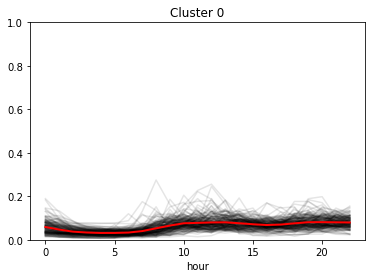

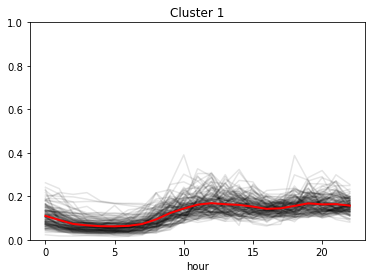

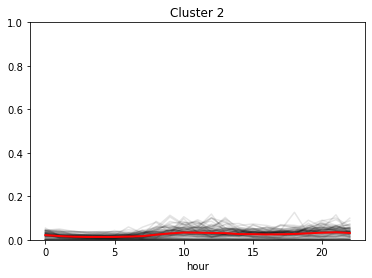

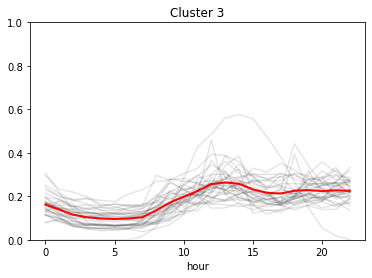

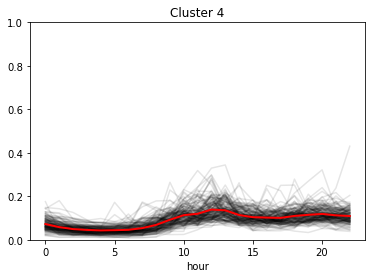

In [62]:
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

## Closer look at cluster 5

In [63]:
# cl4_df = kmeans_df[kmeans_df["cluster"]==4]

In [64]:
# cl4_lst = list(cl4_df["Fall_ge1"].unique())
# cl4_lst

In [65]:
# df[df["Fall_ge1"].isin(cl4_lst)].loc["2010-05-02"].groupby("Fall_ge1").Electricity_Demand.plot()

In [66]:
# cl6_df = df[df["Fall_ge1"].isin(cl6_lst)]
# cl6_df["Daten_Herkunft"].unique()